<a href="https://colab.research.google.com/github/avyasharma/Skunkworks-iForests/blob/main/UnsupervisedTrainingofFriedmanIsoForestv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.datasets import make_friedman1
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split,ParameterGrid
import pandas as pd
from sklearn import model_selection 
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt
from __future__ import print_function
import ipywidgets as widgets
from sklearn.metrics import make_scorer, recall_score,roc_auc_score,precision_score,f1_score
import collections
from copy import copy

In [ ]:
# Helper functions

def add_y_as_feature(X,y):
  # make a copy so that we don't modify X
    ret = copy(X)
    ret['y1']=y
    return ret


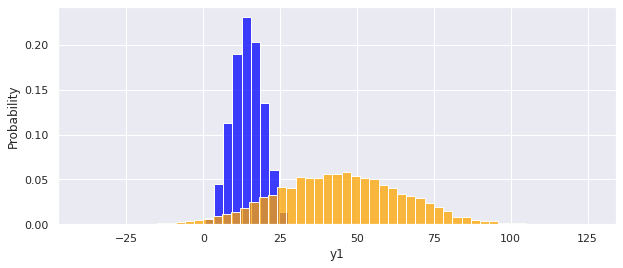

In [ ]:
# Create synthetic dataset using make_friedman1. N = 100k
df1=None
df2=None
X1, y1 = make_friedman1(
    n_samples=20000, n_features = 5 , random_state=1)


# Create another synthetic dataset with noise.
X2, y2 = make_friedman1(
    n_samples=10000, n_features = 5, random_state=1, noise=20,)

y2 += 30

# Convert from numpy arrays to pandas dataframes
X1 = pd.DataFrame(X1, columns = ["x1", "x2", "x3", "x4", "x5"])
y1 = pd.DataFrame(y1, columns = ["y1"])
X2 = pd.DataFrame(X2, columns = ["x1", "x2", "x3", "x4", "x5"])
y2 = pd.DataFrame(y2, columns = ["y1"])

import seaborn as sns
sns.set()
# n_bins = len(X)//100
# We can set the number of bins with the `bins` kwarg
fig, ax = plt.subplots(figsize=(10,4))
sns.histplot(y1['y1'], bins = 'auto', stat='probability', color = 'blue', binwidth = 3, ax=ax)
sns.histplot(y2['y1'], bins = 'auto', stat='probability', color = 'orange', binwidth = 3, ax=ax);

,x1,x2,x3,x4,x5,y1
0,0.417022,0.720324,0.000114,0.302333,0.146756,16.852205
1,0.092339,0.186260,0.345561,0.396767,0.538817,7.678848
2,0.419195,0.685220,0.204452,0.878117,0.027388,18.513197
3,0.670468,0.417305,0.558690,0.140387,0.198101,10.164178
4,0.800745,0.968262,0.313424,0.692323,0.876389,18.487972
...,...,...,...,...,...,...
9995,0.262843,0.488224,0.122288,0.559378,0.693075,15.835656
9996,0.020417,0.267466,0.205267,0.997075,0.019197,11.975641
9997,0.628463,0.590054,0.186363,0.894264,0.151762,20.856644
9998,0.924045,0.787591,0.542900,0.833562,0.620191,19.020638


In [ ]:
# Since Isoforest is an unsupervised learning problem, we will need to add the y variable as a feature.

df1 = add_y_as_feature(X1,y1)
x_train = df1[:10000]
outsample = add_y_as_feature(X2,y2)
insample = df1[10000:]


(         x1        x2        x3        x4        x5         y1
 0  0.417022  0.720324  0.000114  0.302333  0.146756  16.852205
 1  0.092339  0.186260  0.345561  0.396767  0.538817   7.678848
 2  0.419195  0.685220  0.204452  0.878117  0.027388  18.513197
 3  0.670468  0.417305  0.558690  0.140387  0.198101  10.164178
 4  0.800745  0.968262  0.313424  0.692323  0.876389  18.487972,
          x1        x2        x3        x4        x5         y1
 0  0.417022  0.720324  0.000114  0.302333  0.146756   8.850894
 1  0.092339  0.186260  0.345561  0.396767  0.538817  25.843459
 2  0.419195  0.685220  0.204452  0.878117  0.027388  28.970348
 3  0.670468  0.417305  0.558690  0.140387  0.198101  -5.169944
 4  0.800745  0.968262  0.313424  0.692323  0.876389  34.101910)

#Kurtosis as a form of feature selection

* Kurtosis
measures the ‘peakness’ of univariate distribution. Kurtosis is sensitive to the presence of anomalies and hence it
is a good attribute selector for anomaly detection. After
Kurtosis has provided a ranking for each attribute, a subspace of attributes is selected according to this ranking to
construct each tree. The result is promising and we show
that the detection performance improves when the subspace
size comes close to the original number of attributes. There
are other attribute selectors that we can choose from, e.g.,
Grubb’s test. However, in this section, we are only concern with showcasing iForest’s ability to work with an attribute selec* 

Liu, Fei Tony, Kai Ming Ting, and Zhi-Hua Zhou. "Isolation forest." 2008 eighth ieee international conference on data mining. IEEE, 2008. **bold text**

In [9]:
from scipy.stats import kurtosis
kur_X1 = kurtosis(X1,fisher = False)
kur_y1 = kurtosis(y1, fisher = False)

print(kur_X1,kur_y1)

[1.80542239 1.78755067 1.79625746 1.79441604 1.78819626] [2.53115152]


#Training and testing


In [15]:
import datetime
start = datetime.datetime.now()

clf = IsolationForest(random_state=47)

param_grid = ParameterGrid({
              'contamination': np.arange(.01,.1,.01),
              'n_estimators': list(range(75, 150, 5,)), 
              'max_samples': ['auto'],  
              'max_features': list(range(1,7)), 
              'bootstrap': [True, False], 
              'n_jobs': [-1]})
results = []
TPR = []
FPR = []
y_true = np.array(list([-1]*10000))
for param in param_grid:
    clf.set_params(**param)
    clf.fit(df1)
    outsample_pred = clf.predict(outsample)
    insample_pred = clf.predict(insample)
    # true_positive_rate = correctly labeled outliers from outsample / total outliers
    # false_positive_rate = incorrectly labeled outliers from insample / total outliers
    true_positive_rate = pd.DataFrame(outsample_pred).value_counts()[-1] / 10000
    false_positive_rate = pd.DataFrame(insample_pred).value_counts()[-1] / 10000
    results.append([ true_positive_rate, param, false_positive_rate])
    FPR.append(false_positive_rate)
    TPR.append(true_positive_rate)
    print(param, true_positive_rate, false_positive_rate)


#using SK-learn

end = datetime.datetime.now()
print(end-start)

{'bootstrap': True, 'contamination': 0.01, 'max_features': 1, 'max_samples': 'auto', 'n_estimators': 75, 'n_jobs': -1} -1    0.1852
dtype: float64 -1    0.0107
dtype: float64
{'bootstrap': True, 'contamination': 0.01, 'max_features': 1, 'max_samples': 'auto', 'n_estimators': 80, 'n_jobs': -1} -1    0.1987
dtype: float64 -1    0.0105
dtype: float64
{'bootstrap': True, 'contamination': 0.01, 'max_features': 1, 'max_samples': 'auto', 'n_estimators': 85, 'n_jobs': -1} -1    0.2008
dtype: float64 -1    0.0106
dtype: float64
{'bootstrap': True, 'contamination': 0.01, 'max_features': 1, 'max_samples': 'auto', 'n_estimators': 90, 'n_jobs': -1} -1    0.2019
dtype: float64 -1    0.0105
dtype: float64
{'bootstrap': True, 'contamination': 0.01, 'max_features': 1, 'max_samples': 'auto', 'n_estimators': 95, 'n_jobs': -1} -1    0.1851
dtype: float64 -1    0.0105
dtype: float64
{'bootstrap': True, 'contamination': 0.01, 'max_features': 1, 'max_samples': 'auto', 'n_estimators': 100, 'n_jobs': -1} -1   

In [18]:
# Create dataframe of parameter grid search results
bootstrap = []
contam = []
max_features = []
max_samples  = []
n_estimators = []
tpr = []
fpr = []
for x in results:
  bootstrap.append(str(x[1]['bootstrap'])) # wrap in string. workaround to issue in https://community.plotly.com/t/plotly-express-scatter-color-not-showing/25962
  contam.append(x[1]['contamination'])
  max_features.append(x[1]['max_features'])
  max_samples.append(x[1]['max_samples'])
  n_estimators.append(x[1]['n_estimators'])
  tpr.append(float(x[0]))
  fpr.append(float(x[2]))

In [20]:
dic = {'bootstrap': bootstrap,
       'contamination': contam,
       'max_features': max_features,
       'max_samples': max_samples,
       'n_estimators': n_estimators,
       'tpr': tpr,
       'fpr': fpr}

results_df = pd.DataFrame(dic)

In [21]:
results_df.head()

,bootstrap,contamination,max_features,max_samples,n_estimators,tpr,fpr
0,True,0.01,1,auto,75,0.1852,0.0107
1,True,0.01,1,auto,80,0.1987,0.0105
2,True,0.01,1,auto,85,0.2008,0.0106
3,True,0.01,1,auto,90,0.2019,0.0105
4,True,0.01,1,auto,95,0.1851,0.0105


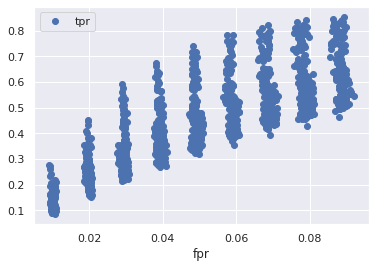

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
results_df.plot(x='fpr', y='tpr', style='o');

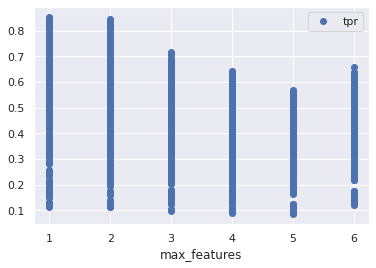

In [25]:
results_df.plot(x='max_features', y='tpr', style='o');

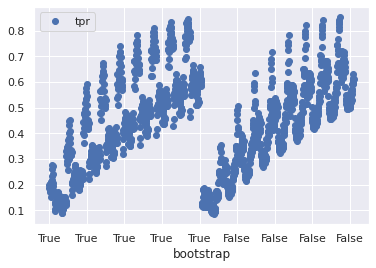

In [24]:
# No bootstrap seems to have better performance........ k o o l
results_df.plot(x='bootstrap', y='tpr', style='o', );

''

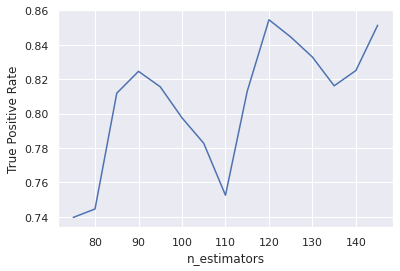

In [ ]:
num_est = []
medians = []
for num in results_df['n_estimators'].unique():
  #print(results_df[results_df['n_estimators']==num]['tpr'].max())
  num_est.append(num)
  medians.append(results_df[results_df['n_estimators']==num]['tpr'].max())

plt.plot(num_est,medians)
plt.xlabel("n_estimators")
plt.ylabel("True Positive Rate")
;

In [22]:
import plotly.express as px

# https://plotly.com/python/3d-scatter-plots/

fig = px.scatter_3d(results_df,
                    x='contamination',
                    y='fpr',
                    z='tpr',
                    color='bootstrap',
                    size_max=18)
fig.show()
